Goal is to create an ML, noise-robust control example from the PCAP data set

Steps / to-dos:
1. Get the PCA data in
1. Try to reproduce the PCA results (2 vectors w 92%)
1. Try to improve on it with NMF, log scaling, 2 category columns, etc.
1. Create a noisy data set, check robustness
1. Create a hypothetical time series (w/ noise/drift)
1. Create a DQN to control it?

In [24]:
%matplotlib inline

import csv
import scipy
import seaborn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#Import Plotting Tools
from metabolicModelingTools import plotModel,generateReport
#from tuneModels import generate_test_points

#Import Scikit learn functions
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import cross_val_score, RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFECV,RFE
from sklearn.decomposition import PCA

#Import Models
from sklearn.svm import SVR
from sklearn.ensemble import BaggingRegressor, RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.linear_model import LassoLarsIC
from sklearn.gaussian_process import GaussianProcessRegressor

In [25]:
t_data = pd.read_csv("LimonenePCAPdata.csv", index_col=0)
#t_data = t_data[t_data.PCAPpaper != "n"]
t_data.shape

(30, 14)

In [26]:
t_data.head(5)

,Limonene,Optical Density,AtoB,PMK,idi,MK,PMD,LS,GPPS,HMGR,HMGS,InducedOD,InducerLevel,PCAPpaper
Line,,,,,,,,,,,,,,
2X-Hh,71.05431,4.18000,0.1280,0.4947,0.9970,0.1686,0.8337,3.8485,0.3746,0.1193,0.2126,H,h,y
2X-Hl,2.46049,5.86600,0.0219,0.3407,1.0516,0.2256,1.0540,1.4751,0.0605,0.0280,0.0429,H,l,y
2X-Hm,52.13119,4.40867,0.0627,0.1899,0.9134,0.1060,0.6176,2.8899,0.1837,0.0894,0.1721,H,m,y
2X-Lh,53.60310,4.96467,0.2335,0.7463,2.3338,0.3196,1.7450,9.1728,0.2534,0.6998,0.6607,L,h,y
2X-Ll,5.98466,6.36200,0.0457,0.4691,1.5995,0.2709,1.9367,3.0677,0.1423,0.0998,0.1210,L,l,y


In [27]:
X = t_data.drop(['Limonene','Optical Density', 'PCAPpaper'], axis=1)
y = t_data['Limonene']
X.head(5)

,AtoB,PMK,idi,MK,PMD,LS,GPPS,HMGR,HMGS,InducedOD,InducerLevel
Line,,,,,,,,,,,
2X-Hh,0.1280,0.4947,0.9970,0.1686,0.8337,3.8485,0.3746,0.1193,0.2126,H,h
2X-Hl,0.0219,0.3407,1.0516,0.2256,1.0540,1.4751,0.0605,0.0280,0.0429,H,l
2X-Hm,0.0627,0.1899,0.9134,0.1060,0.6176,2.8899,0.1837,0.0894,0.1721,H,m
2X-Lh,0.2335,0.7463,2.3338,0.3196,1.7450,9.1728,0.2534,0.6998,0.6607,L,h
2X-Ll,0.0457,0.4691,1.5995,0.2709,1.9367,3.0677,0.1423,0.0998,0.1210,L,l


In [28]:
from sklearn.preprocessing import LabelEncoder
le_OD = LabelEncoder()
le_ind = LabelEncoder()
X['OD_encoded'] = le_OD.fit_transform(X.InducedOD)
X['ind_encoded'] = le_ind.fit_transform(X.InducerLevel)

In [29]:
X = X.drop(['InducedOD', 'InducerLevel'], axis = 1)

In [30]:
X.head()

,AtoB,PMK,idi,MK,PMD,LS,GPPS,HMGR,HMGS,OD_encoded,ind_encoded
Line,,,,,,,,,,,
2X-Hh,0.1280,0.4947,0.9970,0.1686,0.8337,3.8485,0.3746,0.1193,0.2126,0,0
2X-Hl,0.0219,0.3407,1.0516,0.2256,1.0540,1.4751,0.0605,0.0280,0.0429,0,1
2X-Hm,0.0627,0.1899,0.9134,0.1060,0.6176,2.8899,0.1837,0.0894,0.1721,0,2
2X-Lh,0.2335,0.7463,2.3338,0.3196,1.7450,9.1728,0.2534,0.6998,0.6607,1,0
2X-Ll,0.0457,0.4691,1.5995,0.2709,1.9367,3.0677,0.1423,0.0998,0.1210,1,1


In [31]:
from sklearn.preprocessing import OneHotEncoder
X1 = OneHotEncoder(sparse = False, categorical_features = [9, 10]).fit_transform(X)

In [86]:
X1
X2 = np.array(X1).tolist()

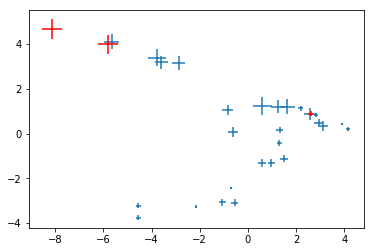

In [33]:
#PCA analysis
limonene_pca = PCA(n_components=2)
transformed_points = limonene_pca.fit_transform(X2[0:27])
    
transformed_x = [-1*point[0] for point in transformed_points]
transformed_y = [point[1] for point in transformed_points]

new_transformed_points = limonene_pca.transform(X2[27:])
new_transformed_x = [-1*point[0] for point in new_transformed_points]
new_transformed_y = [point[1] for point in new_transformed_points]

principal_components = limonene_pca.components_
principal_components[0] = [-1*value for value in principal_components[0]]
    #print(principal_components)
    
    #Plot Using Seaborn...
y_scaled = [item/max(y)*400 for item in y]
plt.scatter(transformed_x,transformed_y,marker='+',s=y_scaled[0:27],linewidths=1)
plt.scatter(new_transformed_x,new_transformed_y,color='red',marker='+',s=y_scaled[27:],linewidths=1)
plt.show()

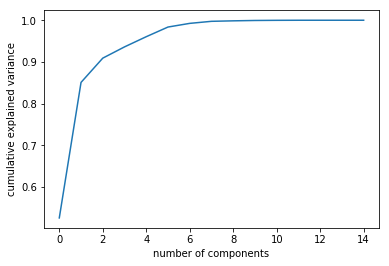

In [34]:
pca = PCA().fit(X2[0:27])
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

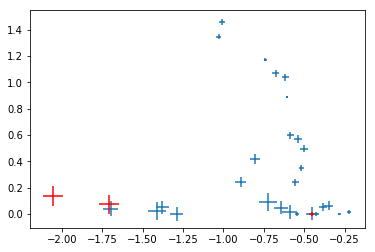

In [35]:
#NMF
from sklearn.decomposition import NMF
limonene_nmf = NMF(n_components=2, init='random', random_state=0)
transformed_points = limonene_nmf.fit_transform(X2[0:27])
    
transformed_x = [-1*point[0] for point in transformed_points]
transformed_y = [point[1] for point in transformed_points]

new_transformed_points = limonene_nmf.transform(X2[27:])
new_transformed_x = [-1*point[0] for point in new_transformed_points]
new_transformed_y = [point[1] for point in new_transformed_points]

nmf_components = limonene_nmf.components_
nmf_components[0] = [-1*value for value in principal_components[0]]
       
    #Plot Using Seaborn...
y_scaled = [item/max(y)*400 for item in y]
plt.scatter(transformed_x,transformed_y,marker='+',s=y_scaled[0:27],linewidths=1)
plt.scatter(new_transformed_x,new_transformed_y,color='red',marker='+',s=y_scaled[27:],linewidths=1)
plt.show()

In [93]:
import numpy.random as rand

# Add some noise to X2
X3 = X2[0:27]
N = rand.normal(scale=.0,size=np.shape(X3)) + np.ones(shape=np.shape(X3))
print(np.shape(N))
print(np.shape(X2[0:27]))
N[:,0:6] = 1
# print(N)
X3 = N * X3
# print(np.shape(X3))
# print(X3)

(27, 15)
(27, 15)


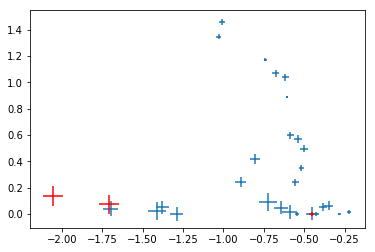

In [94]:
#NMF
from sklearn.decomposition import NMF
limonene_nmf = NMF(n_components=2, init='random', random_state=0)
transformed_points = limonene_nmf.fit_transform(X3)
    
transformed_x = [-1*point[0] for point in transformed_points]
transformed_y = [point[1] for point in transformed_points]

new_transformed_points = limonene_nmf.transform(X2[27:])
new_transformed_x = [-1*point[0] for point in new_transformed_points]
new_transformed_y = [point[1] for point in new_transformed_points]

nmf_components = limonene_nmf.components_
nmf_components[0] = [-1*value for value in principal_components[0]]
       
    #Plot Using Seaborn...
y_scaled = [item/max(y)*400 for item in y]
plt.scatter(transformed_x,transformed_y,marker='+',s=y_scaled[0:27],linewidths=1)
plt.scatter(new_transformed_x,new_transformed_y,color='red',marker='+',s=y_scaled[27:],linewidths=1)
plt.show()

In [60]:
score = 'r2' #Use R^2 as model scoring metric
#score = None
cv=ShuffleSplit(n_splits=10) 
#cv=None

In [61]:
#Define and Add Brians Regressor
#"preprocessing": {"__dtype":"cys.model.StandardScaler"}
#"algorithm":{"__dtype":"cys.model.LinearRegressionEnsemble", "n_estimators":1000,"random_state":null}
#"feature_selection":{"__dtype":"cys.model.RFE", "degree":2,"interaction_only":true,"thresh":0.95,"include_bias":true}

polynomialRegressor = Pipeline([('Scaler',StandardScaler()),
                                ('Polynomial Features',PolynomialFeatures(degree=2, include_bias=True, interaction_only=True)),
                                ('Feature Reduction',RFECV(Ridge(),cv=cv, scoring=score)),
                                ('Linear Regressor',BaggingRegressor(base_estimator=Ridge(),
                                                                     n_estimators=100, max_samples=.8,
                                                                     bootstrap=False,
                                                                     bootstrap_features=False,
                                                                     random_state=None))])

supportVectorRegressor = Pipeline([('Scaler',StandardScaler()),
                                   ('SVR',SVR())])

models = {'Support Vector Regressor':supportVectorRegressor,
          'Random Forest Regressor':RandomForestRegressor(),
          'Linear Regressor':LassoLarsIC(),
          'Polynomial Regressor':polynomialRegressor,
          'Gaussian Process Regressor':GaussianProcessRegressor()}

In [63]:
#Define the Dictionaries of Parameters to optimize for each model...
parameter_dists = {}
parameter_dists['Support Vector Regressor'] = {'SVR__C': scipy.stats.expon(scale=100),
                                               'SVR__gamma': scipy.stats.expon(scale=.1),
                                               'SVR__kernel': ['rbf']}


#Hyperparamter optimize the Models with defined parameter distributions
for model in parameter_dists:
    models[model] = RandomizedSearchCV(models[model],
                                       parameter_dists[model], 
                                       n_iter=25, 
                                       scoring=score, 
                                       fit_params=None,
                                       cv=cv).fit(X2,y)

ValueError: Invalid parameter SVR for estimator RandomizedSearchCV(cv=ShuffleSplit(n_splits=10, random_state=None, test_size='default',
       train_size=None),
          error_score='raise',
          estimator=Pipeline(memory=None,
     steps=[('Scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('SVR', SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False))]),
          fit_params=None, iid=True, n_iter=25, n_jobs=1,
          param_distributions={'SVR__C': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1d95eda0>, 'SVR__gamma': <scipy.stats._distn_infrastructure.rv_frozen object at 0x1a1d95e3c8>, 'SVR__kernel': ['rbf']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring='r2', verbose=0). Check the list of available parameters with `estimator.get_params().keys()`.

In [ ]:
for model in models:
    cross_validation = cross_val_score(models[model],X2,y=y,cv=cv,scoring=score )
    print(model,sum(cross_validation)/len(cross_validation))

In [ ]:
X_test = X2[27:]
y_test = y[27:]
X = X2[:27]
y = y[:27]

for model in models:
    models[model].fit(X,y)

In [ ]:
for model in models:
    print(model)
    plotModel(models[model],X,y,pcs=principal_components)

In [ ]:
print('Maximum Limonene Titre: ',max(y))
print(sorted(y))

for model in models:
    print('')
    print(model)
    print('===============')
    print('Predicted Limonene | Measured Limonene')
    for strain,target in zip(X_test,y_test):
        print(models[model].predict([strain])[0],'|',target)